# Hugging Face transformers installation & UCF101 Subset preparation

In [1]:
!pip install -q pytorchvideo transformers evaluate

In [2]:
import numpy as np 
import pandas as pd 

In [3]:
import os

ucf101_root = '/kaggle/input/ucf101-subset/UCF101_subset/'
ids_to_labels = dict()
labels_to_ids = dict()
cnt_label = -1
for directory in os.listdir(ucf101_root+'train'):
    cnt_label += 1
    ids_to_labels[cnt_label] = directory
    labels_to_ids[directory] = cnt_label
"""
print(fnames_to_ids)
print(ids_to_labels)
print(labels_to_ids)
"""

'\nprint(fnames_to_ids)\nprint(ids_to_labels)\nprint(labels_to_ids)\n'

In [4]:
import torch
device = "cuda:0" if torch.cuda.is_available() else "cpu"

# Load VideoMAE model


In [5]:
from transformers import VideoMAEImageProcessor, VideoMAEForVideoClassification

model_ckpt = "MCG-NJU/videomae-base"

image_processor = VideoMAEImageProcessor.from_pretrained(model_ckpt)
model = VideoMAEForVideoClassification.from_pretrained(
    model_ckpt,
    label2id=labels_to_ids,
    id2label=ids_to_labels,
    ignore_mismatched_sizes=True,  # provide this in case you're planning to fine-tune an already fine-tuned checkpoint
)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


preprocessor_config.json:   0%|          | 0.00/271 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/725 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/377M [00:00<?, ?B/s]

Some weights of VideoMAEForVideoClassification were not initialized from the model checkpoint at MCG-NJU/videomae-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Prepare transforms and dataset

In [6]:
import pytorchvideo.data

from pytorchvideo.transforms import (
    ApplyTransformToKey,
    Normalize,
    RandomShortSideScale,
    RemoveKey,
    ShortSideScale,
    UniformTemporalSubsample,
    CutMix
)

from torchvision.transforms import (
    Compose,
    Lambda,
    RandomCrop,
    RandomHorizontalFlip,
    Resize,
)

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional_tensor.py:5: UserWarning: The torchvision.transforms.functional_tensor module is deprecated in 0.15 and will be **removed in 0.17**. Please don't rely on it. You probably just need to use APIs in torchvision.transforms.functional or in torchvision.transforms.v2.functional.
  warnings.warn(


In [7]:
mean = image_processor.image_mean
std = image_processor.image_std
if "shortest_edge" in image_processor.size:
    height = width = image_processor.size["shortest_edge"]
else:
    height = image_processor.size["height"]
    width = image_processor.size["width"]
resize_to = (height, width)

num_frames_to_sample = model.config.num_frames
sample_rate = 4
fps = 30
clip_duration = num_frames_to_sample * sample_rate / fps
num_classes = len(labels_to_ids)

# Training dataset transformations.
train_transform = Compose(
    [
        ApplyTransformToKey(
            key="video",
            transform=Compose(
                [
                    UniformTemporalSubsample(num_frames_to_sample),
                    Lambda(lambda x: x / 255.0),
                    Normalize(mean, std),
                    RandomShortSideScale(min_size=256, max_size=320),
                    RandomCrop(resize_to),
                    RandomHorizontalFlip(p=0.5)
                    #CutMix(num_classes=num_classes)
                ]
            ),
        ),
    ]
)

# Training dataset.
train_dataset = pytorchvideo.data.Ucf101(
    data_path=os.path.join(ucf101_root, "train"),
    clip_sampler=pytorchvideo.data.make_clip_sampler("random", clip_duration),
    decode_audio=False,
    transform=train_transform,
)

# Validation and evaluation datasets' transformations.
val_transform = Compose(
    [
        ApplyTransformToKey(
            key="video",
            transform=Compose(
                [
                    UniformTemporalSubsample(num_frames_to_sample),
                    Lambda(lambda x: x / 255.0),
                    Normalize(mean, std),
                    Resize(resize_to),
                ]
            ),
        ),
    ]
)

# Validation and evaluation datasets.
val_dataset = pytorchvideo.data.Ucf101(
    data_path=os.path.join(ucf101_root, "val"),
    clip_sampler=pytorchvideo.data.make_clip_sampler("uniform", clip_duration),
    decode_audio=False,
    transform=val_transform,
)

test_dataset = pytorchvideo.data.Ucf101(
    data_path=os.path.join(ucf101_root, "test"),
    clip_sampler=pytorchvideo.data.make_clip_sampler("uniform", clip_duration),
    decode_audio=False,
    transform=val_transform,
)

In [8]:
train_dataset.num_videos, val_dataset.num_videos, test_dataset.num_videos

(300, 30, 75)

In [9]:
image_processor


VideoMAEImageProcessor {
  "crop_size": {
    "height": 224,
    "width": 224
  },
  "do_center_crop": true,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "feature_extractor_type": "VideoMAEFeatureExtractor",
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_processor_type": "VideoMAEImageProcessor",
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "shortest_edge": 224
  }
}

In [10]:
sample_video = next(iter(train_dataset))
sample_video.keys()

dict_keys(['video', 'video_name', 'video_index', 'clip_index', 'aug_index', 'label'])

In [11]:
def investigate_video(sample_video):
    """Utility to investigate the keys present in a single video sample."""
    for k in sample_video:
        if k == "video":
            print(k, sample_video["video"].shape)
        else:
            print(k, sample_video[k])

    print(f"Video label: {ids_to_labels[sample_video[k]]}")


investigate_video(sample_video)



video torch.Size([3, 16, 224, 224])
video_name v_Basketball_g01_c01.avi
video_index 210
clip_index 0
aug_index 0
label 7
Video label: BandMarching


In [12]:
import imageio
import numpy as np
from IPython.display import Image


def unnormalize_img(img):
    """Un-normalizes the image pixels."""
    img = (img * std) + mean
    img = (img * 255).astype("uint8")
    return img.clip(0, 255)


def create_gif(video_tensor, filename="sample.gif"):
    """Prepares a GIF from a video tensor.
    
    The video tensor is expected to have the following shape:
    (num_frames, num_channels, height, width).
    """
    frames = []
    for video_frame in video_tensor:
        frame_unnormalized = unnormalize_img(video_frame.permute(1, 2, 0).numpy())
        frames.append(frame_unnormalized)
    kargs = {"duration": 0.25}
    imageio.mimsave(filename, frames, "GIF", **kargs)
    return filename


def display_gif(video_tensor, gif_name="sample.gif"):
    """Prepares and displays a GIF from a video tensor."""
    video_tensor = video_tensor.permute(1, 0, 2, 3)
    gif_filename = create_gif(video_tensor, gif_name)
    return Image(filename=gif_filename)

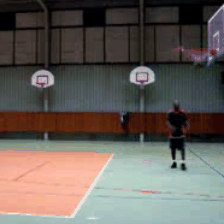

In [13]:
video_tensor = sample_video["video"]
display_gif(video_tensor)

# Prepare training routine

In [ ]:
from transformers import TrainingArguments, Trainer

#new_model_name = f"AI_Tech2_finetuned_UCF101_subset"
num_epochs = 4
batch_size = 4

if not os.path.exists('/kaggle/working/ckpt_dir'):
    os.mkdir('/kaggle/working/ckpt_dir')


args = TrainingArguments(
    output_dir = '/kaggle/working/ckpt_dir',
    remove_unused_columns=False,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=False,
    max_steps=(train_dataset.num_videos // batch_size) * num_epochs,
    report_to="none"
)



In [ ]:
import evaluate

metric = evaluate.load("accuracy")
def compute_metrics(eval_pred):
    """Computes accuracy on a batch of predictions."""
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)

In [14]:
def collate_fn(examples):
    """The collation function to be used by `Trainer` to prepare data batches."""
    # permute to (num_frames, num_channels, height, width)
    pixel_values = torch.stack(
        [example["video"].permute(1, 0, 2, 3) for example in examples]
    )
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

In [ ]:
trainer = Trainer(
    model,
    args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
    data_collator=collate_fn,
)

In [ ]:

from huggingface_hub import notebook_login

notebook_login()



In [ ]:
import wandb
wandb.init(mode="disabled")

In [ ]:
train_results = trainer.train()

In [ ]:
trainer.evaluate(test_dataset)

In [15]:
num_classes

10

In [16]:
cutmix_aug = CutMix(num_classes=num_classes)
def collate_fn_aug(examples):
    """The collation function to be used by `Trainer` to prepare data batches."""
    # permute to (num_frames, num_channels, height, width)
    pixel_values = torch.stack(
        [example["video"] for example in examples]
    )
    print(pixel_values.shape)
    labels = torch.tensor([example["label"] for example in examples])
    pixel_values, labels = cutmix_aug(pixel_values, labels)
    pixel_values = pixel_values.permute(0, 2, 1, 3, 4)
    print(pixel_values.shape)
    print(labels.shape)
    return {"pixel_values": pixel_values, "labels": labels}

In [17]:
def collate_CutMix_train(examples):
    pixel_values = examples['video']
    labels = examples['label']
    pixel_values, labels = cutmix_aug(pixel_values, labels)
    pixel_values = pixel_values.permute(0, 2, 1, 3, 4)
    return {"pixel_values": pixel_values, "labels": labels}

In [ ]:
trainer = Trainer(
    model,
    args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
    data_collator=collate_fn_aug,
)

In [18]:
batch = [next(iter(train_dataset)) for _ in range(4)]

In [ ]:
ct_bt = collate_fn_aug(batch)
#len(ct_bt)
ct_bt_2 = collate_fn(batch)
print(ct_bt_2['pixel_values'].shape)
print(ct_bt_2['labels'].shape)
print(ct_bt['labels'])
print(ct_bt_2['labels'])

torch.Size([4, 3, 16, 224, 224])
torch.Size([4, 16, 3, 224, 224])
torch.Size([4, 10])


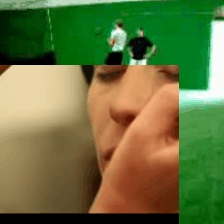

In [19]:
ct_bt = collate_fn_aug(batch)
display_gif(ct_bt['pixel_values'][3].permute(1, 0, 2, 3))

In [21]:
# ========================================================= DATALOADERS =================================================================
from torch.utils.data import DataLoader

batch_size = 4
num_workers = 2

dataloaders = dict()
dataloaders['train'] = DataLoader(train_dataset,
                                  batch_size=batch_size,
                                  num_workers=num_workers,
                                  pin_memory=True,
                                  drop_last=True)
dataloaders['val'] = DataLoader(val_dataset,
                                  batch_size=batch_size,
                                  num_workers=num_workers,
                                  pin_memory=True,
                                   drop_last=True)
dataloaders['test'] = DataLoader(test_dataset,
                                  batch_size=batch_size,
                                  num_workers=num_workers,
                                  pin_memory=True)

In [22]:
#========================================================== OWN TRAINER ==================================================================
from sklearn import metrics
from tqdm import tqdm
from torch import nn

def run_epoch(model, phase, dataloader, device, optimizer, criterion):
    if phase == 'train':
        model.train()
    else:
        model.eval()

    softmax = nn.Softmax(dim=1).to(device)
    running_loss = 0.0
    running_corrects = 0
    y_test = []
    y_pred = []
    all_elems_count = 0
    cur_tqdm = tqdm(dataloader)
    for examples in cur_tqdm:
        #print(examples['video'].shape)
        bz = examples['label'].shape[0]
        all_elems_count += bz
        
        batch = collate_CutMix_train(examples)
        inputs = batch['pixel_values'].to(device, non_blocking=True)
        labels = batch['labels'].to(device, non_blocking=True)
        
        outputs = model(inputs)
        scores = softmax(outputs.logits)
        #print(outputs.logits)
        loss = criterion(scores, labels)

        if phase == 'train':
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        _, preds = torch.max(scores, 1)
        _, labels = torch.max(labels, 1)
        y_test.extend(labels.detach().cpu().numpy())
        y_pred.extend(preds.detach().cpu().numpy())
        running_loss += loss.item() * bz
        corrects_cnt = torch.sum(preds.detach() == labels.detach())
        running_corrects += corrects_cnt
        show_dict = {'Loss': f'{loss.item():.6f}',
                    'Corrects': f'{corrects_cnt.item()}/{bz}',
                    'Accuracy': f'{(corrects_cnt * 100 / bz).item():.3f}%'}
        cur_tqdm.set_postfix(show_dict)

    print("Calculating metrics...")
    f1_micro = metrics.f1_score(y_test, y_pred, average="micro")
    f1_macro = metrics.f1_score(y_test, y_pred, average="macro")
    f1_weighted = metrics.f1_score(y_test, y_pred, average="weighted")
    epoch_loss = running_loss / all_elems_count
    epoch_acc = running_corrects.float().item() / all_elems_count
    return {"epoch_loss": epoch_loss,
            "epoch_acc": epoch_acc, 
            "f1_micro": f1_micro, 
            "f1_macro": f1_macro, 
            "f1_weighted": f1_weighted}

In [23]:
import time
import math

def run_model_training(model, dataloaders, n_epochs, device, optimizer, criterion, prev_metrics=None, log_out_dir=None):
    
    phases = ['train', 'val']
    metrics = ['epoch_loss', 'epoch_acc', 'f1_micro', 'f1_macro', 'f1_weighted']
    start_epoch = 1
    if prev_metrics is None:
        saved_metrics = {phase: {metric: list() for metric in metrics} for phase in phases}
    else:
        saved_metrics = prev_metrics
        start_epoch = len(saved_metrics['train']['epoch_loss'])+1
    
    print("="*100)
    print(f"Starting model --{model.name}-- training with params:")
    print(f"Optimizer: {optimizer}")
    print(f"Criterion: {criterion}")
    
    for epoch in range(start_epoch, start_epoch+n_epochs+1):
        start_time = time.time()
        print("=" * 100)
        print(f'Epoch {epoch}/{start_epoch+n_epochs}')
        print('-' * 10)
        
        for phase in phases:
            print(f"Current phase: {phase}")
            if phase == 'train':
                epoch_metrics = run_epoch(model, phase, dataloaders[phase], device, optimizer, criterion)
            else:
                with torch.inference_mode():
                    epoch_metrics = run_epoch(model, phase, dataloaders[phase], device, optimizer, criterion)
            print(f"Metrics for phase={phase}:")
            for met in list(epoch_metrics.keys()):
                saved_metrics[phase][met].append(epoch_metrics[met])
                print(f"{met}: {epoch_metrics[met]}")
    
        end_time = time.time()
        epoch_time = end_time - start_time
        print("-" * 10)
        print(f"Epoch Time: {math.floor(epoch_time // 60)}:{math.floor(epoch_time % 60):02d}")
    
        model.eval()
        
    print("*** Training Completed ***")
    return saved_metrics

In [24]:
from torch import optim
from torch import nn
from transformers import get_scheduler

learning_rate = 2e-4

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
num_epochs = 7
num_training_steps = num_epochs * 75 # train = 300, 300/4 = 75
lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

In [25]:
model.to(device)
model.name = 'VideoMAE_CutMix_Adam_Linear'

In [37]:
del model
torch.cuda.empty_cache()

In [26]:
metrics = run_model_training(model, dataloaders, n_epochs=7, device=device, optimizer=optimizer, criterion=criterion)

Starting model --VideoMAE_CutMix_Adam_Linear-- training with params:
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    initial_lr: 0.0002
    lr: 0.0002
    maximize: False
    weight_decay: 0
)
Criterion: CrossEntropyLoss()
Epoch 1/8
----------
Current phase: train


74it [01:49,  1.47s/it, Loss=2.304224, Corrects=1/4, Accuracy=25.000%]


Calculating metrics...
Metrics for phase=train:
epoch_loss: 2.316525240202208
epoch_acc: 0.06756756756756757
f1_micro: 0.06756756756756757
f1_macro: 0.049808482482990045
f1_weighted: 0.049964294566836015
Current phase: val


0it [00:00, ?it/s]/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be co

Calculating metrics...
Metrics for phase=val:
epoch_loss: 2.307964605443618
epoch_acc: 0.014705882352941176
f1_micro: 0.014705882352941176
f1_macro: 0.0047619047619047615
f1_weighted: 0.0035014005602240893
----------
Epoch Time: 1:59
Epoch 2/8
----------
Current phase: train


74it [01:51,  1.50s/it, Loss=2.384025, Corrects=0/4, Accuracy=0.000%] 


Calculating metrics...
Metrics for phase=train:
epoch_loss: 2.3117347246891744
epoch_acc: 0.10135135135135136
f1_micro: 0.10135135135135136
f1_macro: 0.07846025861685799
f1_weighted: 0.07884261726189223
Current phase: val


0it [00:00, ?it/s]/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be co

Calculating metrics...
Metrics for phase=val:
epoch_loss: 2.303108846440035
epoch_acc: 0.11764705882352941
f1_micro: 0.11764705882352941
f1_macro: 0.03696048632218846
f1_weighted: 0.04219560164491329
----------
Epoch Time: 2:01
Epoch 3/8
----------
Current phase: train


74it [01:51,  1.50s/it, Loss=2.374012, Corrects=0/4, Accuracy=0.000%] 


Calculating metrics...
Metrics for phase=train:
epoch_loss: 2.3052301793485075
epoch_acc: 0.11486486486486487
f1_micro: 0.11486486486486487
f1_macro: 0.06320628646715602
f1_weighted: 0.06336271689532559
Current phase: val


0it [00:00, ?it/s]/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be co

Calculating metrics...
Metrics for phase=val:
epoch_loss: 2.3094617899726417
epoch_acc: 0.058823529411764705
f1_micro: 0.058823529411764705
f1_macro: 0.030965005302226935
f1_weighted: 0.016779988771754725
----------
Epoch Time: 2:01
Epoch 4/8
----------
Current phase: train


74it [01:51,  1.50s/it, Loss=2.237899, Corrects=2/4, Accuracy=50.000%]


Calculating metrics...
Metrics for phase=train:
epoch_loss: 2.30113964145248
epoch_acc: 0.125
f1_micro: 0.125
f1_macro: 0.05839419475655431
f1_weighted: 0.05780174486284037
Current phase: val


0it [00:00, ?it/s]/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be co

Calculating metrics...
Metrics for phase=val:
epoch_loss: 2.27686565062579
epoch_acc: 0.22058823529411764
f1_micro: 0.22058823529411764
f1_macro: 0.15714285714285714
f1_weighted: 0.17771199388846448
----------
Epoch Time: 2:01
Epoch 5/8
----------
Current phase: train


74it [01:50,  1.50s/it, Loss=2.248667, Corrects=1/4, Accuracy=25.000%]


Calculating metrics...
Metrics for phase=train:
epoch_loss: 2.290251557891433
epoch_acc: 0.14864864864864866
f1_micro: 0.14864864864864866
f1_macro: 0.10016937146949252
f1_weighted: 0.09973479567645771
Current phase: val


0it [00:00, ?it/s]/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be co

Calculating metrics...
Metrics for phase=val:
epoch_loss: 2.212868466096766
epoch_acc: 0.2647058823529412
f1_micro: 0.2647058823529412
f1_macro: 0.10016578249336869
f1_weighted: 0.16718676860664688
----------
Epoch Time: 2:00
Epoch 6/8
----------
Current phase: train


74it [01:50,  1.50s/it, Loss=2.216871, Corrects=1/4, Accuracy=25.000%] 


Calculating metrics...
Metrics for phase=train:
epoch_loss: 2.286140193810334
epoch_acc: 0.15202702702702703
f1_micro: 0.15202702702702703
f1_macro: 0.08883569376026272
f1_weighted: 0.09003617610837439
Current phase: val


0it [00:00, ?it/s]/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be co

Calculating metrics...
Metrics for phase=val:
epoch_loss: 2.2522133658914005
epoch_acc: 0.2647058823529412
f1_micro: 0.2647058823529412
f1_macro: 0.08702127659574468
f1_weighted: 0.17722152690863582
----------
Epoch Time: 2:00
Epoch 7/8
----------
Current phase: train


74it [01:51,  1.50s/it, Loss=2.192920, Corrects=1/4, Accuracy=25.000%]


Calculating metrics...
Metrics for phase=train:
epoch_loss: 2.3158210242116772
epoch_acc: 0.13851351351351351
f1_micro: 0.13851351351351351
f1_macro: 0.04977425801199023
f1_weighted: 0.05044688312026037
Current phase: val


0it [00:00, ?it/s]/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be co

Calculating metrics...
Metrics for phase=val:
epoch_loss: 2.2559980504653034
epoch_acc: 0.19117647058823528
f1_micro: 0.1911764705882353
f1_macro: 0.06885428253615129
f1_weighted: 0.13411961002420994
----------
Epoch Time: 2:01
Epoch 8/8
----------
Current phase: train


74it [01:50,  1.50s/it, Loss=2.267921, Corrects=1/4, Accuracy=25.000%]


Calculating metrics...
Metrics for phase=train:
epoch_loss: 2.303903286521499
epoch_acc: 0.11486486486486487
f1_micro: 0.11486486486486487
f1_macro: 0.07594483620552396
f1_weighted: 0.0755959057707356
Current phase: val


0it [00:00, ?it/s]/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be co

Calculating metrics...
Metrics for phase=val:
epoch_loss: 2.2524984584135166
epoch_acc: 0.17647058823529413
f1_micro: 0.17647058823529413
f1_macro: 0.06756272401433691
f1_weighted: 0.14853468269028042
----------
Epoch Time: 2:01
*** Training Completed ***


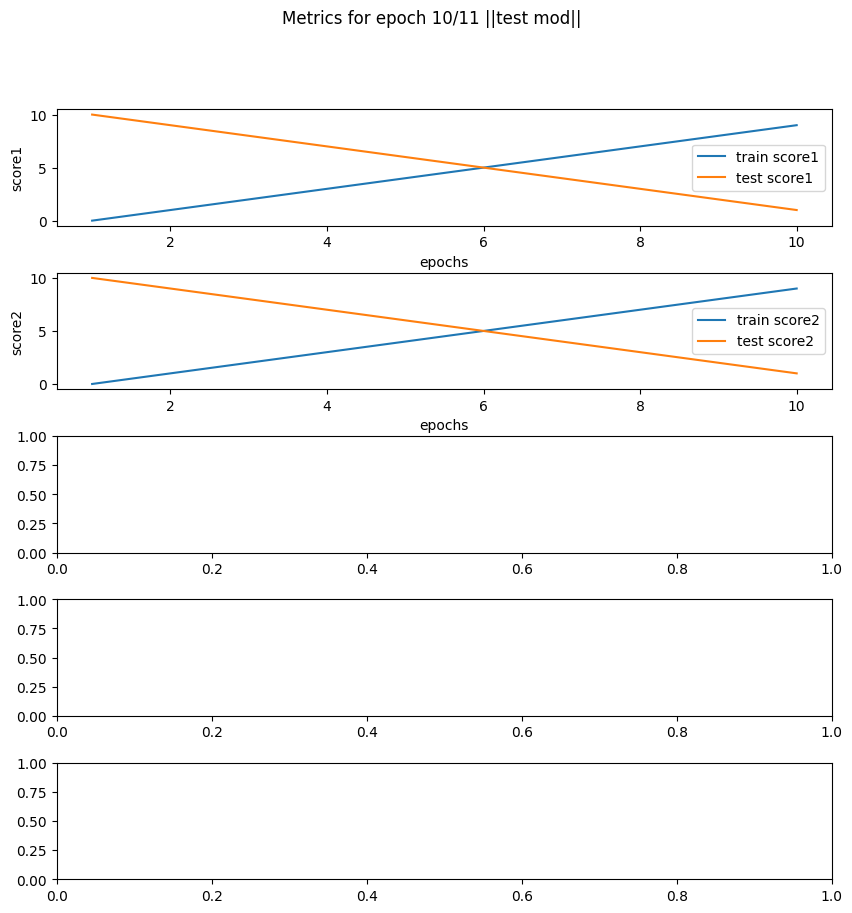

In [27]:
import matplotlib.pyplot as plt

def plot_epoch_stats(metrics, epoch_inf, m_name, out_dir = None):
    phases = list(metrics.keys())
    mets = list(metrics[phases[0]].keys())
    
    fig, axs = plt.subplots(5)
    fig.suptitle(f'Metrics for epoch {epoch_inf[0]}/{epoch_inf[1]+1} ||{m_name}||')
    for idx, m in enumerate(mets):
        for ph in phases:
            axs[idx].plot(range(1, epoch_inf[0]+1), metrics[ph][m], label=f'{ph} {m}')
        axs[idx].set(xlabel='epochs', ylabel=f'{m}')
        #axs[idx].set_title(f'{m}')
        axs[idx].legend(loc="center right")
    fig.set_figheight(10)
    fig.set_figwidth(10)
    plt.subplots_adjust(hspace=0.4)
    plt.show()
    if not out_dir is None:
        plt.savefig(f'{out_dir}stats_for_epoch_{epoch_inf[0]}')
        
    plt.close('all')
    
bench_plt = {'train': {'score1': range(10),
                      'score2': range(10)},
            'test': {'score1': range(10, 0, -1),
                    'score2': range(10, 0, -1)}}
plot_epoch_stats(bench_plt, [10,10], "test mod")

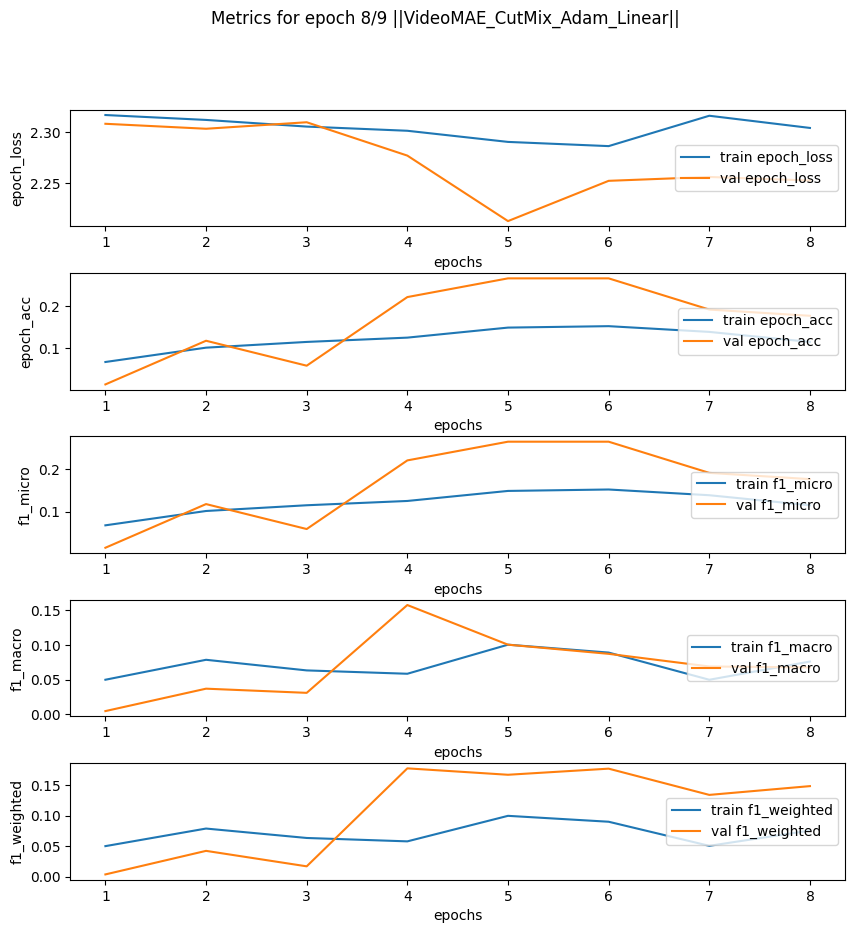

In [31]:
plot_epoch_stats(metrics, list([8,8]), model.name)